# word2vec介绍：语句情感分析

之前的文章，我们了解了word2vec的原理和实现，这篇文章讲一讲应用，以语句情感分析为例。我们使用斯坦福大学标记好的数据进行情感分析，下面是整个分析过程。

文末有完整代码的链接。

## 准备数据

首先我们来看看本文即将使用的使用的格式。

In [54]:
# 读取数据
dataset = StanfordSentiment()
tokens = dataset.tokens()
nWords = len(tokens)

In [55]:
#读取WordVectors数据
wordVectors = glove.loadWordVectors(tokens)

In [56]:
dimVectors = wordVectors.shape[1]

In [57]:
trainset = dataset.getTrainSentences() # 读取训练数据
nTrain = len(trainset) # 得到训练数据大小
trainFeatures = np.zeros((nTrain, dimVectors)) # 初始化训练数据
trainLabels = np.zeros((nTrain,), dtype=np.int32) # 初始化训练数据标签

查看其中一条数据

In [58]:
#查看训练集中的数据，以第10条数据为例，
trainset[10]

(['good',
  'fun',
  ',',
  'good',
  'action',
  ',',
  'good',
  'acting',
  ',',
  'good',
  'dialogue',
  ',',
  'good',
  'pace',
  ',',
  'good',
  'cinematography',
  '.'],
 4)

可见，训练数据是一个tuple类型数据，由两部分组成。
第一部分是由句子的单词和标点符号组成的列表。
第二部分是一个数字，对于`trainset[10]`来说是4.

In [63]:
#查看训练数据的情感标签
print("第10条句子的情感标签是:%d"%trainset[10][1])

第10条句子的情感标签是:4


4代表该条数据的情感标签。根据我们的编码，用0-4分别代表“非常消极”、“消极”、“中立”、“积极”、“非常积极”五种情绪。所以这里的4代表“非常积极”，观察句子中的单词如“good fun”、"good action"等，确实都传达了非常积极的情绪。

## 训练集

我们的目的是对句子进行情感分析，首先第一步是得到句向量，这里采用简单的求句子中的所有词向量的均值作为句向量。

In [71]:
#返回句向量
def getSentenceFeatures(tokens, wordVectors, sentence):
    sentVector = np.zeros((wordVectors.shape[1],))
    
    #句子中所有词向量的均值作为句向量
    for s in sentence:
        sentVector += wordVectors[tokens[s], :]
    sentVector *= 1.0 / len(sentence)

    #异常: 维度错误
    assert sentVector.shape == (wordVectors.shape[1],)
    return sentVector

In [72]:
#得到训练集特征和标签
for i in xrange(nTrain):
    words, trainLabels[i] = trainset[i]
    trainFeatures[i, :] = getSentenceFeatures(tokens, wordVectors, words)

In [73]:
print(trainFeatures[10])
print("情感标签：%d"%trainLabels[10])

[-0.16387972  0.20204722 -0.47888633 -0.02866439  0.59194327 -0.00511122
 -0.251245   -0.24204667 -0.19511567  0.28125222 -0.06910394  0.24802711
 -0.44788167 -0.06569694  0.25088556  0.00449078  0.43044278  0.1269115
 -0.1807188  -0.45737333 -0.01543883  0.56428061  0.23471494 -0.08217072
  0.49469244 -1.34156167 -0.27914839  0.04475539  0.30786586 -0.22476379
  3.295855    0.3423513  -0.1358725  -0.25282167  0.08905994 -0.05950239
 -0.09389856  0.47957611  0.10088722 -0.21478967 -0.08732637  0.33898479
 -0.09445356 -0.19614556  0.06076611  0.10367686  0.00907689 -0.04100611
  0.10756272  0.62726003]
情感标签：4


以上就是训练集中第10条数据的句向量和情感标签，因为我们导入的词向量是glove算法得到的50维词向量，因此句向量的维度也是50.   

## 开发集

接下来我们准备开发集，开发集用于对算法进行交叉验证，进而筛选得到最优算法。

In [74]:
# Prepare dev set features
devset = dataset.getDevSentences() #得到开发集的句子
nDev = len(devset) # 开发集大小
devFeatures = np.zeros((nDev, dimVectors)) #初始化开发集
devLabels = np.zeros((nDev,), dtype=np.int32)#初始化开发集标签

#得到开发集的句向量
for i in xrange(nDev):
    words, devLabels[i] = devset[i]
    devFeatures[i, :] = getSentenceFeatures(tokens, wordVectors, words)

同样我们看一下开发集中第250条数据的句向量和标签

In [75]:
print(devFeatures[250])
print("情感标签：%d"%devLabels[250])

[  4.81241556e-01   1.40070000e-02   6.92502222e-02  -6.86841111e-02
   4.31634444e-01   1.95371567e-01  -3.21193556e-01   6.51922222e-02
  -1.24563333e-01   2.06758111e-01  -1.91932222e-01   2.11828111e-01
  -3.29489444e-01   2.38200000e-02   4.95806667e-01   2.76432222e-01
   3.40766667e-01  -1.33433333e-03  -1.23777444e-01  -6.73770000e-01
  -1.18427778e-02   4.39728222e-01   2.62109111e-01   2.00073567e-01
   4.51153111e-01  -1.50233000e+00  -4.97133333e-01   1.49537333e-01
   4.91483333e-01  -5.09132222e-01   2.88996222e+00   1.70082044e-01
  -3.43100000e-01  -3.52352111e-01   1.29942333e-01  -2.36533333e-02
  -2.04228889e-01   2.76246778e-01   1.02244222e-01  -4.55481889e-01
   3.13804799e-02   2.57222000e-01   2.39707667e-01   2.63615556e-02
  -4.27062222e-02   1.86264556e-01   1.79544333e-01  -7.92555556e-04
  -6.18602111e-02   1.87534444e-01]
情感标签：4


## 测试集

准备测试集。

In [77]:
# Prepare test set features
testset = dataset.getTestSentences()
nTest = len(testset)
testFeatures = np.zeros((nTest, dimVectors))
testLabels = np.zeros((nTest,), dtype=np.int32)
for i in xrange(nTest):
    words, testLabels[i] = testset[i]
    testFeatures[i, :] = getSentenceFeatures(tokens, wordVectors, words)

## 模型

有了数据集和标签，现在问题转化常规的监督学习问题。我们可以使用监督学习的算法包括逻辑回归、朴素贝叶斯、决策树等。

### 正则项参数

为了防止过拟合，增加模型的泛化能力，我们采取简单有效的方法，增加正则项。`getRegularizationValues()`函数用来生成正则项的参数$\lambda$，以列表的形式保存在参数`values`中。

In [87]:
def getRegularizationValues():
    """
    返回一个正则项参数的列表.
    """
    values = None  # Assign a list of floats in the block below
    values = np.logspace(-4, 2, num=100, base=10)

    return sorted(values)

In [79]:
getRegularizationValues()[0:5]

[0.0001,
 0.00011497569953977356,
 0.00013219411484660288,
 0.00015199110829529331,
 0.00017475284000076829]

通过生成等比数列的方式，我们能够得到数值范围为$[10^{-4}, 10^2]$的100个值，上面的结果显示了其中前5个值。

后面我们将循环测试这100个超参数，以得到最优的正则化参数$\lambda$。

### 训练模型

下面我们选取一个正则项参数进行模型测试，选用的是逻辑回归模型。

In [86]:
reg = regValues[10] #正则项参数

In [85]:
clf = LogisticRegression(C=1.0 / (reg + 1e-12)) #生成模型
clf.fit(trainFeatures, trainLabels) #训练模型

LogisticRegression(C=2477.076349855804, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

`LogisticRegression`的参数C是正则项$\lambda$的倒数，正则项越大，C越小，惩罚效果越强。另外这里分母与一个非常小的正数相加避免出现分母为0的情况。
接下来在训练集上测试。

In [89]:
# 在训练集上测试
pred = clf.predict(trainFeatures)

使用准确率作为算法性能的衡量标准。

In [90]:
def accuracy(y, yhat):
    """ Precision for classifier """
    assert (y.shape == yhat.shape)
    return np.sum(y == yhat) * 100.0 / y.size

In [91]:
trainAccuracy = accuracy(trainLabels, pred)
print "训练集准确率 (%%): %f" % trainAccuracy

训练集准确率 (%): 39.911049


我们在训练集上得到了39.91%的准确率。接下来在开发集和测试集进行测试。

In [92]:
# 开发集测试
pred = clf.predict(devFeatures)
devAccuracy = accuracy(devLabels, pred)
print "开发集准确率 (%%): %f" % devAccuracy

# 测试集测试
pred = clf.predict(testFeatures)
testAccuracy = accuracy(testLabels, pred)
print "测试集准确率 (%%): %f" % testAccuracy

开发集准确率 (%): 36.330609
测试集准确率 (%): 37.013575


我们再开发集得到了36.33%的准确率，在测试集得到了37.01%的准确率，均比在训练集得到的准确率低，说明我们的算法出现了过拟合。

### 模型调参

为了得到合适的参数（这里就是正则化参数$\lambda$），我们将不同的参数代入模型并训练，根据我们的测量标准“准确率”，评判模型性能，进而选择最优参数。

In [94]:
results = [] # 用于保存结果数据
regValues = getRegularizationValues()
#循环测试超参数
for reg in regValues:
    clf = LogisticRegression(C=1.0 / (reg + 1e-12))
    clf.fit(trainFeatures, trainLabels)

    # Test on train set
    pred = clf.predict(trainFeatures)
    trainAccuracy = accuracy(trainLabels, pred)

    # Test on dev set
    pred = clf.predict(devFeatures)
    devAccuracy = accuracy(devLabels, pred)

    # Test on test set
    # Note: always running on test is poor style. Typically, you should
    # do this only after validation.
    pred = clf.predict(testFeatures)
    testAccuracy = accuracy(testLabels, pred)

    results.append({
        "reg": reg,
        "clf": clf,
        "train": trainAccuracy,
        "dev": devAccuracy,
        "test": testAccuracy})

运行上面的代码，得到超参的结果，并保存在变量results中，我们来看一下结果的形（篇幅原因我们只显示了前10个结果）

In [99]:
# Print the accuracies
print ""
print "=== Recap ==="
print "Reg\t\tTrain\tDev\tTest"
for result in results[1:10]:
    print "%.2E\t%.3f\t%.3f\t%.3f" % (
        result["reg"],
        result["train"],
        result["dev"],
        result["test"])
print ""


=== Recap ===
Reg		Train	Dev	Test
1.15E-04	39.876	36.421	37.014
1.32E-04	39.911	36.512	37.014
1.52E-04	39.911	36.331	37.014
1.75E-04	39.911	36.331	37.014
2.01E-04	39.899	36.512	37.059
2.31E-04	39.923	36.331	36.968
2.66E-04	39.911	36.331	36.968
3.05E-04	39.958	36.331	36.968
3.51E-04	39.958	36.421	36.968



以第一条结果为例说明，1.15E-04代表正则项参数，39.876是训练集准确率，36.421是开发集准确率，37.014是测试集准确率。很明显，这一行出现了过拟合。

接下来，有了结果，我们就可以选择效果最好的模型参数作为我们的正则项参数，如何选择呢？

可以选择模型在开发集上得到最好准确率的参数作为最优参数，注意：不能使用测试集的准确率作为评判标准，因为在现实中，模型确定之前，我们是看不到测试集的。

In [100]:
def chooseBestModel(results):
    """
    选择最好的模型
    """
    bestResult = None
    bestResult = max(results, key=lambda x: x["dev"])

    return bestResult

In [127]:
bestResult = chooseBestModel(results)
print "最好的正则项参数为：%0.2E" % bestResult["reg"]
print "测试集准确率为： (%%): %f" % bestResult["test"]

最好的正则项参数为：1.23E+01
测试集准确率为： (%): 37.556561


如果把所有参数和准确率的关系画图展示，可以直观的观察变化趋势。

In [125]:
def plotRegVsAccuracy(regValues, results, filename):
    """ Make a plot of regularization vs accuracy """
    plt.plot(regValues, [x["train"] for x in results])
    plt.plot(regValues, [x["dev"] for x in results])
    plt.xscale('log')
    plt.xlabel('regulazation')
    plt.ylabel("accuracy")
    plt.legend(['train', 'dev'], loc='upper left')
    plt.savefig(filename)

In [126]:
plotRegVsAccuracy(regValues, results, "q4_reg_v_acc.png")

上图中蓝色曲线代表开发集的准确率随参数变化的，橘色曲线代表开发集准确率随参数变化的曲线。可见在参数为10左右，开发集达到最好的准确率，这与我们得到的结果：1.23E+01 一致。

## 误差分析

### 混淆矩阵

我们仅得到了37%左右的准确率，说明我们的算法还有很大的改进空间，首先需要采取一种方式观察预测结果，可以使用混淆矩阵的方式。

In [131]:
def outputConfusionMatrix(features, labels, clf, filename):
    """ Generate a confusion matrix """
    pred = clf.predict(features)
    cm = confusion_matrix(labels, pred, labels=range(5))
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
    plt.colorbar()
    classes = ["- -", "-", "neut", "+", "+ +"]
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(filename)

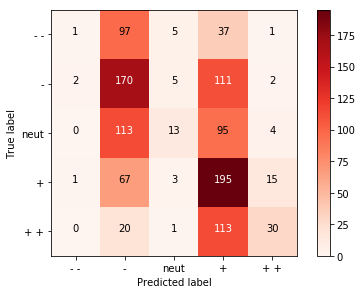

In [132]:
outputConfusionMatrix(devFeatures, devLabels, bestResult["clf"],"q4_dev_conf.png")

混淆矩阵有两个维度，我们首先看第一个维度：y轴，y轴代表语句的真实标签，从0到4（这利用从--到++表示），分别代表从“非常消极”到“非常积极”。同样，x轴代表我们对语句的预测值从--到++，对应方格内的数字代表落在此的分类数量。   
举例说明：左上角的方格代表，真实标签为--我们的预测值也是--的句子的数量，为1。第一行第二格代表真实标签是--而我们的预测值是-的句子数量，为97。   
所以说，混淆矩阵的对角线上的方格代表预测正确的语句的数量。
但是我们的模型预测结果集中在-和+，对于++、--和中立的语句预测效果不好，其中一个原因就是我们利用语句中的词向量的均值代表词句子，导致特别消极与消极之间，以及特别积极与积极之间的差距变小，很难分辨。

## 完整代码

为了节省篇幅，文章删减了很多代码及注释，主要关注整体编程思路。
读者想测试完整代码请[点击这里]()。
使用方式：

- 点击右侧绿色的‘clone or download’按钮
- 下载后的代码在‘sentiment analysis’文件夹中
- 通过命令行进入该文件夹后先执行'get_datasets.sh'下载数据
- 通过命令行进入该文件夹后执行python q4_sentiment.py

注意，全部代码在python2.6下测试通过


有任何问题，欢迎留言讨论。